In [1010]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Get Data

In [1011]:
#get data
ConfirmedData = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
DeathsData = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
RecoveredData = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
Populations2016 = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [1012]:
#add label
ConfirmedData['Type'] = "Confirmed"
DeathsData['Type'] = "Deaths"
RecoveredData['Type'] = "Recovered"

In [1013]:
#join data
frames = [ConfirmedData, DeathsData, RecoveredData]
data = pd.concat(frames)
data[:5]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,Type
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,114,147,177,212,272,322,411,599,599.0,Confirmed
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,839,825,878,889,924,963,1007,1086,1086.0,Confirmed
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,226,243,266,313,345,385,432,455,455.0,Confirmed
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,2,2.0,Confirmed
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,428,566,673,790,900,1030,1183,1306,1306.0,Confirmed


# Transform Data

In [1014]:
#rename columns
data.rename(columns={'Province/State': 'ProvinceState'}, inplace=True)
data.rename(columns={'Country/Region': 'CountryRegion'}, inplace=True)
data.drop(columns=['Lat','Long'], inplace=True)

In [1015]:
#remove bookend spaces
data['ProvinceState'] = data['ProvinceState'].str.strip()
data['CountryRegion'] = data['CountryRegion'].str.strip()

In [1016]:
#melt data
alldata = data.melt(id_vars=["ProvinceState", "CountryRegion","Type"], var_name=["Date"], value_name="Count")
alldata = alldata.sort_values(by=['Count'], ascending=False)
alldata[:5]

,ProvinceState,CountryRegion,Type,Date,Count
87328,Hubei,China,Confirmed,3/20/20,67800.0
85825,Hubei,China,Confirmed,3/19/20,67800.0
88831,Hubei,China,Confirmed,3/21/20,67800.0
90334,Hubei,China,Confirmed,3/22/20,67800.0
84322,Hubei,China,Confirmed,3/18/20,67800.0


In [1017]:
#change datatypes
alldata['Date']= pd.to_datetime(alldata['Date'])
alldata["ProvinceState"]= alldata["ProvinceState"].astype(str)
alldata["CountryRegion"]= alldata["CountryRegion"].astype(str)

# Meta Filters

In [1018]:
#advance minimum date option
#alldata = alldata[alldata['Date'] > '2020-02-18']

In [1019]:
#drop China option
#alldata = alldata[alldata['CountryRegion'] != 'China']

# Aggregate and Prep Country Data

In [1020]:
#aggregate by country
countrydata = alldata.groupby(['CountryRegion','Type','Date'], as_index=False).agg({"Count": "sum"})
countrydata[:5]

,CountryRegion,Type,Date,Count
0,Afghanistan,Confirmed,2020-01-22,0.0
1,Afghanistan,Confirmed,2020-01-23,0.0
2,Afghanistan,Confirmed,2020-01-24,0.0
3,Afghanistan,Confirmed,2020-01-25,0.0
4,Afghanistan,Confirmed,2020-01-26,0.0


In [1021]:
#get top 10 countries in list
topcountries = countrydata.groupby('CountryRegion', as_index=False).agg({"Count": "max"})
topcountries = topcountries.sort_values(by=['Count'], ascending=False)
topcountries.reset_index(inplace=True)
topcountries.drop(columns=['index'], inplace=True)
print(topcountries[:10])
topcountrylist = topcountries['CountryRegion'][:10].tolist()

    CountryRegion    Count
0           China  81439.0
1           Italy  59138.0
2              US  33276.0
3           Spain  28768.0
4         Germany  24873.0
5            Iran  21638.0
6          France  16176.0
7    Korea, South   8897.0
8     Switzerland   7245.0
9  United Kingdom   5741.0


In [1022]:
#isolate data for top countries
topcountrydata = countrydata[countrydata['CountryRegion'].isin(topcountrylist)]

In [1023]:
#isolate confirmed data for top countries
topcountryconfirmed = topcountrydata[topcountrydata['Type'].isin(['Confirmed'])]
topcountryconfirmed[:5]

,CountryRegion,Type,Date,Count
6138,China,Confirmed,2020-01-22,548.0
6139,China,Confirmed,2020-01-23,643.0
6140,China,Confirmed,2020-01-24,920.0
6141,China,Confirmed,2020-01-25,1406.0
6142,China,Confirmed,2020-01-26,2075.0


In [1024]:
"""#plot confirmed by top 10 countries
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Confirmed Cases in 10 Highest Confirmed Count Countries", fontsize=20)

sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountryconfirmed.sort_values('Date'), sort=True, markers=True)"""

'#plot confirmed by top 10 countries\nfig, ax = plt.subplots()\nfig.set_size_inches(12,6)\n\ndate_form = DateFormatter("%m-%d")\nax.xaxis.set_major_formatter(date_form)\nax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))\nax.set_title("Confirmed Cases in 10 Highest Confirmed Count Countries", fontsize=20)\n\nsns.lineplot(x=\'Date\', y=\'Count\', hue=\'CountryRegion\', data=topcountryconfirmed.sort_values(\'Date\'), sort=True, markers=True)'

In [1025]:
#isolate recovered data for top countries
topcountryrecovered = topcountrydata[topcountrydata['Type'].isin(['Recovered'])]
topcountryrecovered[:5]

,CountryRegion,Type,Date,Count
6262,China,Recovered,2020-01-22,28.0
6263,China,Recovered,2020-01-23,30.0
6264,China,Recovered,2020-01-24,36.0
6265,China,Recovered,2020-01-25,39.0
6266,China,Recovered,2020-01-26,49.0


In [1026]:
"""#plot recovered by top 10 countries
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Recovered Cases in 10 Highest Confirmed Count Countries", fontsize=20)

sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountryrecovered.sort_values('Date'), sort=True, markers=True)"""

'#plot recovered by top 10 countries\nfig, ax = plt.subplots()\nfig.set_size_inches(12,6)\n\ndate_form = DateFormatter("%m-%d")\nax.xaxis.set_major_formatter(date_form)\nax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))\nax.set_title("Recovered Cases in 10 Highest Confirmed Count Countries", fontsize=20)\n\nsns.lineplot(x=\'Date\', y=\'Count\', hue=\'CountryRegion\', data=topcountryrecovered.sort_values(\'Date\'), sort=True, markers=True)'

In [1027]:
#isolate deaths data for top countries
topcountrydeaths = topcountrydata[topcountrydata['Type'].isin(['Deaths'])]
topcountrydeaths[:5]

,CountryRegion,Type,Date,Count
6200,China,Deaths,2020-01-22,17.0
6201,China,Deaths,2020-01-23,18.0
6202,China,Deaths,2020-01-24,26.0
6203,China,Deaths,2020-01-25,42.0
6204,China,Deaths,2020-01-26,56.0


In [1028]:
"""#plot deaths by top 10 countries
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Deaths in 10 Highest Confirmed Count Countries", fontsize=20)

sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountrydeaths.sort_values('Date'), sort=True, markers=True)"""

'#plot deaths by top 10 countries\nfig, ax = plt.subplots()\nfig.set_size_inches(12,6)\n\ndate_form = DateFormatter("%m-%d")\nax.xaxis.set_major_formatter(date_form)\nax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))\nax.set_title("Deaths in 10 Highest Confirmed Count Countries", fontsize=20)\n\nsns.lineplot(x=\'Date\', y=\'Count\', hue=\'CountryRegion\', data=topcountrydeaths.sort_values(\'Date\'), sort=True, markers=True)'

# Plot Country Data

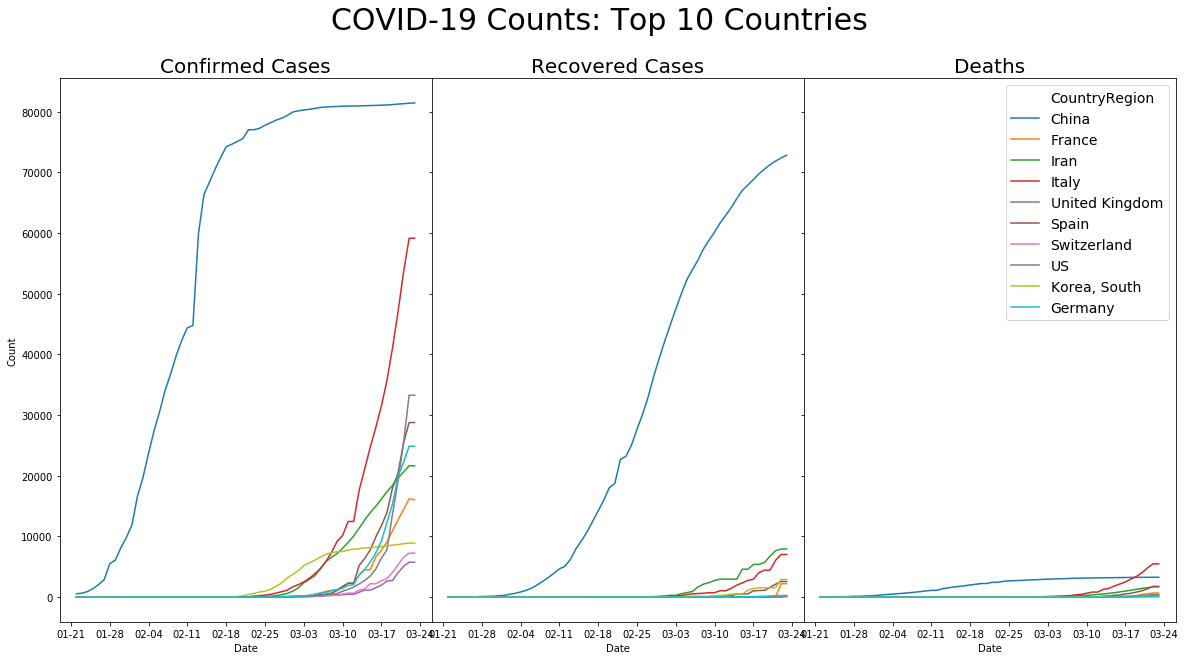

In [1029]:
with sns.plotting_context(rc={"legend.fontsize":14}):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches(20,10)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.suptitle("COVID-19 Counts: Top 10 Countries", fontsize=30)

    date_form = DateFormatter("%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_title("Confirmed Cases", fontsize=20)
    sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountryconfirmed.sort_values('Date'), sort=True, markers=True, ax=ax1, legend=False)

    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax2.set_title("Recovered Cases", fontsize=20)
    #ax2.set_ylabel("")
    sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountryrecovered.sort_values('Date'), sort=True, markers=True, ax=ax2, legend=False)

    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax3.set_title("Deaths", fontsize=20)
    #ax3.set_ylabel("")
    sns.lineplot(x='Date', y='Count', hue='CountryRegion', data=topcountrydeaths.sort_values('Date'), sort=True, markers=True, ax=ax3, legend='full')

In [1030]:
#isolate confirmed data by country
countryconfirmed = countrydata[countrydata['Type'].isin(['Confirmed'])]
countryconfirmed[:5]

,CountryRegion,Type,Date,Count
0,Afghanistan,Confirmed,2020-01-22,0.0
1,Afghanistan,Confirmed,2020-01-23,0.0
2,Afghanistan,Confirmed,2020-01-24,0.0
3,Afghanistan,Confirmed,2020-01-25,0.0
4,Afghanistan,Confirmed,2020-01-26,0.0


In [1031]:
#group by country max confirmed
countrymaxconfirmed = countryconfirmed.groupby(['CountryRegion'], as_index=False).agg({'Count': 'max'})
countrymaxconfirmed[:5]

,CountryRegion,Count
0,Afghanistan,40.0
1,Albania,89.0
2,Algeria,201.0
3,Andorra,113.0
4,Angola,2.0


In [1032]:
#map confirmed cases globally
fig = px.choropleth(countrymaxconfirmed, locations="CountryRegion",
                    color="Count",
                    locationmode='country names',
                    #hover_name="CountryRegion",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show(renderer="notebook_connected")

In [1033]:
#isolate 2016 population data
Populations2016 = Populations2016[Populations2016['Year'].isin(['2016'])]
Populations2016.rename(columns={'Country Name': 'CountryRegion'}, inplace=True)
Populations2016.rename(columns={'Value': '2016Population'}, inplace=True)
Populations2016.drop(columns=['Year'], inplace=True)
Populations2016[:5]

,CountryRegion,Country Code,2016Population
56,Arab World,ARB,4.064527e+08
113,Caribbean small states,CSS,7.245472e+06
170,Central Europe and the Baltics,CEB,1.029741e+08
227,Early-demographic dividend,EAR,3.170542e+09
284,East Asia & Pacific,EAS,2.296786e+09


In [1034]:
#rename population data countries to match covid-19 data
Populations2016.replace(to_replace =["United States"], value ="US", inplace=True)
Populations2016.replace(to_replace =["Korea, Rep."], value ="Korea, South", inplace=True) 
Populations2016.replace(to_replace =["Iran, Islamic Rep."], value ="Iran", inplace=True) 
Populations2016.replace(to_replace =["Russian Federation"], value ="Russia", inplace=True)
Populations2016.replace(to_replace =["Czech Republic"], value ="Czechia", inplace=True)
Populations2016.replace(to_replace =["Egypt, Arab Rep."], value ="Egypt", inplace=True)
Populations2016.replace(to_replace =["Slovak Republic"], value ="Slovakia", inplace=True)
Populations2016.replace(to_replace =["Macedonia, FYR"], value ="North Macedonia", inplace=True)
Populations2016.replace(to_replace =["Brunei Darussalam"], value ="Brunei", inplace=True)
Populations2016.replace(to_replace =["Venezuela, RB"], value ="Venezuela", inplace=True)

In [1035]:
#merge confirmed counts with populations
countrymaxconfirmedwithpop = pd.merge(countrymaxconfirmed, Populations2016, on='CountryRegion', how='left')
countrymaxconfirmedwithpop[:5]

,CountryRegion,Count,Country Code,2016Population
0,Afghanistan,40.0,AFG,34656032.0
1,Albania,89.0,ALB,2876101.0
2,Algeria,201.0,DZA,40606052.0
3,Andorra,113.0,AND,77281.0
4,Angola,2.0,AGO,28813463.0


In [1036]:
#look for countries missing population data
cleanuplist = countrymaxconfirmedwithpop[countrymaxconfirmedwithpop['2016Population'].isnull()]
cleanuplist = cleanuplist.sort_values(by=['Count'], ascending=False)
cleanuplist[:10]

,CountryRegion,Count,Country Code,2016Population
40,Cruise Ship,712.0,NaN,NaN
162,Taiwan*,169.0,NaN,NaN
69,Guadeloupe,56.0,NaN,NaN
139,Reunion,47.0,NaN,NaN
107,Martinique,37.0,NaN,NaN
36,Congo (Kinshasa),30.0,NaN,NaN
60,French Guiana,18.0,NaN,NaN
96,Kyrgyzstan,14.0,NaN,NaN
110,Mayotte,11.0,NaN,NaN
55,Eswatini,4.0,NaN,NaN


In [1037]:
#add percent of population column and isolate top 15 by percent
countrymaxconfirmedwithpop['PercentOfPop'] = round(((countrymaxconfirmedwithpop['Count']/countrymaxconfirmedwithpop['2016Population'])*100),4)
countrymaxconfirmedwithpop = countrymaxconfirmedwithpop.sort_values(by=['PercentOfPop'], ascending=False)
countrymaxconfirmedwithpop = countrymaxconfirmedwithpop[:15]
countrymaxconfirmedwithpop

,CountryRegion,Count,Country Code,2016Population,PercentOfPop
145,San Marino,160.0,SMR,33203.0,0.4819
79,Iceland,568.0,ISL,334252.0,0.1699
3,Andorra,113.0,AND,77281.0,0.1462
102,Luxembourg,798.0,LUX,582972.0,0.1369
100,Liechtenstein,37.0,LIE,37666.0,0.0982
86,Italy,59138.0,ITA,60600590.0,0.0976
160,Switzerland,7245.0,CHE,8372098.0,0.0865
155,Spain,28768.0,ESP,46443959.0,0.0619
113,Monaco,23.0,MCO,38499.0,0.0597
126,Norway,2383.0,NOR,5232929.0,0.0455


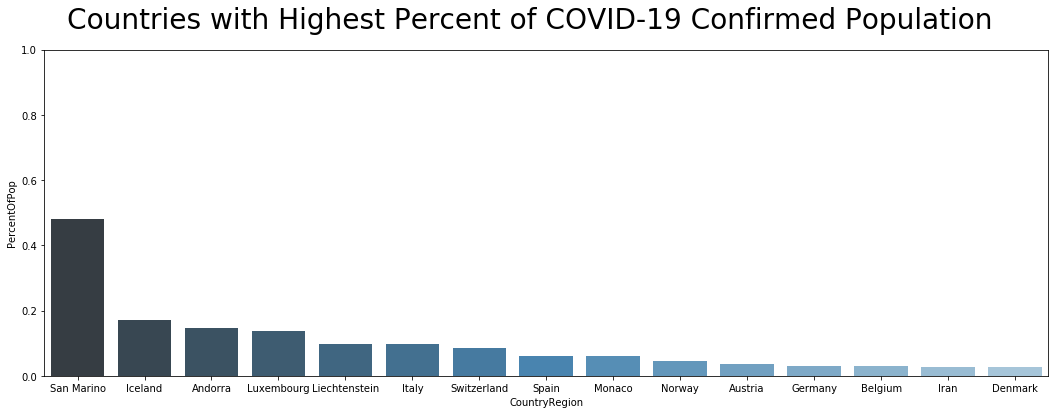

In [1038]:
#bar plot countries with highest percent of confirmed population
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
ax.set(ylim=(0, 1))
fig.suptitle("Countries with Highest Percent of COVID-19 Confirmed Population", fontsize=28)
sns.barplot(x="CountryRegion", y="PercentOfPop", data=countrymaxconfirmedwithpop, palette="Blues_d")

# Aggregate and Prep US State Data

In [1039]:
#isolate US data
USdata = alldata[alldata['CountryRegion'] == "US"]
USdata = USdata.sort_values(by=['Count'], ascending=False)
USdata[:5]

,ProvinceState,CountryRegion,Type,Date,Count
91782,New York,US,Confirmed,2020-03-23,15793.0
90279,New York,US,Confirmed,2020-03-22,15793.0
88776,New York,US,Confirmed,2020-03-21,11710.0
87273,New York,US,Confirmed,2020-03-20,8310.0
85770,New York,US,Confirmed,2020-03-19,5365.0


In [1040]:
#working copy of ProvinceState
USdata['CopyState'] = USdata['ProvinceState']

In [1041]:
#USdata.ProvinceState.unique()

In [1042]:
#replace state names with abbreviations
USdata.CopyState.replace({
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam':'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'West Virginia': 'WV',
    'Washington': 'WA',
    'Virginia': 'VA',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'D.C.':'DC'}, regex=True, inplace=True)

In [1043]:
#pull last 2 characters as abbreviation
USdata['State'] = USdata['CopyState'].str[-2:]
USdata.drop(columns=['CopyState'], inplace=True)

In [1044]:
#USdata.State.unique()

In [1045]:
#checklist for abreviations
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "GU", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "PR", "VI"]

In [1046]:
#find unrecognized abbreviations
unknowns = USdata[~USdata['State'].isin(states)]
unknowns.ProvinceState.unique()

array(['US', 'Diamond Princess', 'Grand Princess'], dtype=object)

In [1047]:
#label unknowns
USdata['State'] = USdata['State'].apply(lambda i: i if i in states else 'Unknown')
USdata[:5]

,ProvinceState,CountryRegion,Type,Date,Count,State
91782,New York,US,Confirmed,2020-03-23,15793.0,NY
90279,New York,US,Confirmed,2020-03-22,15793.0,NY
88776,New York,US,Confirmed,2020-03-21,11710.0,NY
87273,New York,US,Confirmed,2020-03-20,8310.0,NY
85770,New York,US,Confirmed,2020-03-19,5365.0,NY


In [1048]:
#aggregate by state
statedata = USdata.groupby(['State','Type','Date'], as_index=False).agg({'Count': 'sum'})
statedata[:5]

,State,Type,Date,Count
0,AK,Confirmed,2020-01-22,0.0
1,AK,Confirmed,2020-01-23,0.0
2,AK,Confirmed,2020-01-24,0.0
3,AK,Confirmed,2020-01-25,0.0
4,AK,Confirmed,2020-01-26,0.0


In [1049]:
#get top 10 states in list
topstates = statedata.groupby('State', as_index=False).agg({"Count": "max"})
topstates = topstates.sort_values(by=['Count'], ascending=False)
topstates.reset_index(inplace=True)
topstates.drop(columns=['index'], inplace=True)
print(topstates[:10])
topstatelist = topstates['State'][:10].tolist()

  State    Count
0    NY  15793.0
1    WA   1996.0
2    NJ   1914.0
3    CA   1642.0
4    IL   1049.0
5    MI   1037.0
6    LA    837.0
7    FL    830.0
8    MA    646.0
9    TX    627.0


In [1050]:
#isolate data for top states
topstatedata = statedata[statedata['State'].isin(topstatelist)]

In [1051]:
#isolate confimred data for top states
topstateconfirmed = topstatedata[topstatedata['Type'].isin(['Confirmed'])]
topstateconfirmed[:5]

,State,Type,Date,Count
744,CA,Confirmed,2020-01-22,0.0
745,CA,Confirmed,2020-01-23,0.0
746,CA,Confirmed,2020-01-24,0.0
747,CA,Confirmed,2020-01-25,0.0
748,CA,Confirmed,2020-01-26,2.0


In [1052]:
"""#plot confirmed by state
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title("Confirmed Cases by State", fontsize=20)

sns.lineplot(x='Date', y='Count', hue='State', data=topstateconfirmed.sort_values('Date'), sort=True, markers=True)"""

'#plot confirmed by state\nfig, ax = plt.subplots()\nfig.set_size_inches(12,6)\n\ndate_form = DateFormatter("%m-%d")\nax.xaxis.set_major_formatter(date_form)\nax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))\nax.set_title("Confirmed Cases by State", fontsize=20)\n\nsns.lineplot(x=\'Date\', y=\'Count\', hue=\'State\', data=topstateconfirmed.sort_values(\'Date\'), sort=True, markers=True)'

In [1053]:
#isolate recovered data for top states
topstaterecovered = topstatedata[topstatedata['Type'].isin(['Recovered'])]
topstaterecovered[:5]

,State,Type,Date,Count
868,CA,Recovered,2020-01-22,0.0
869,CA,Recovered,2020-01-23,0.0
870,CA,Recovered,2020-01-24,0.0
871,CA,Recovered,2020-01-25,0.0
872,CA,Recovered,2020-01-26,0.0


In [1054]:
#isolate deaths for top states
topstatedeaths = topstatedata[topstatedata['Type'].isin(['Deaths'])]
topstatedeaths[:5]

,State,Type,Date,Count
806,CA,Deaths,2020-01-22,0.0
807,CA,Deaths,2020-01-23,0.0
808,CA,Deaths,2020-01-24,0.0
809,CA,Deaths,2020-01-25,0.0
810,CA,Deaths,2020-01-26,0.0


# Plot US State Data

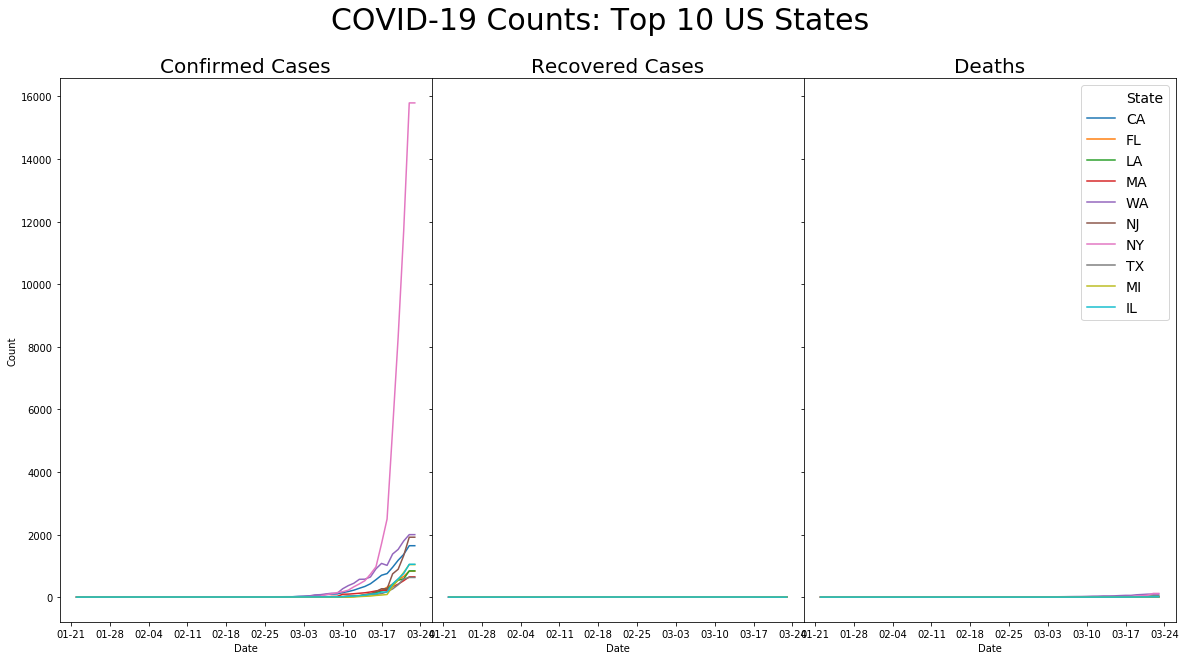

In [1055]:
with sns.plotting_context(rc={"legend.fontsize":14}):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches(20,10)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.suptitle("COVID-19 Counts: Top 10 US States", fontsize=30)

    date_form = DateFormatter("%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_title("Confirmed Cases", fontsize=20)
    sns.lineplot(x='Date', y='Count', hue='State', data=topstateconfirmed.sort_values('Date'), sort=True, markers=True, ax=ax1, legend=False)

    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax2.set_title("Recovered Cases", fontsize=20)
    #ax2.set_ylabel("")
    sns.lineplot(x='Date', y='Count', hue='State', data=topstaterecovered.sort_values('Date'), sort=True, markers=True, ax=ax2, legend=False)

    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax3.set_title("Deaths", fontsize=20)
    #ax3.set_ylabel("")
    sns.lineplot(x='Date', y='Count', hue='State', data=topstatedeaths.sort_values('Date'), sort=True, markers=True, ax=ax3, legend='full')

In [1056]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=topstates['State'],
    z = topstates['Count'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'YlOrRd',
    colorbar_title = "Confirmed Cases",
))

fig.update_layout(
    title_text = 'Current Confirmed COVID-19 Cases',
    geo_scope='usa',
)

fig.show(renderer="notebook_connected")